# Trend Signals Backtest — BTC/USDT

**Part A — Signal visualisation**
Explore what `ADXTrend` and `MASlopeTrend` look like on price data:
how often they detect a trend, how they agree/disagree, and how their
values distribute across bull and bear market bars.

**Part B — Filtered backtest**
Use each trend signal as a regime filter on `BollingerBreakout`.
Compare filtered vs unfiltered performance and interpret the results.

**Part C — Prediction precision evaluation**
Treat `trend_dir` as a directional forecast and measure how accurately
each signal predicts the next bar's (and future bars') market direction.

In [1]:
# ── Configuration ─────────────────────────────────────────────────────────────
SYMBOL    = "BTC/USDT"
SINCE     = "2024-01-01"
UNTIL     = "2024-06-01"

# Bollinger Bands params (baseline strategy)
BB_PERIOD  = 20
BB_NUM_STD = 2.0

# ADXTrend params
ADX_PERIOD    = 14
ADX_THRESHOLD = 25.0

# MASlopeTrend params
MA_PERIOD      = 20
SLOPE_WINDOW   = 5
FLAT_THRESHOLD = 0.05

# Prediction horizons to evaluate (in bars)
HORIZONS = [1, 4, 12, 24]

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

sys.path.insert(0, str(Path().resolve().parent))

from data.fetch import fetch_ohlcv
from signals.trend.adx import ADXTrend
from signals.trend.ma_slope import MASlopeTrend
from strategies.single.basic.bollinger_bands import BollingerBreakout
from backtesting.metrics import compute_metrics

In [3]:
df = fetch_ohlcv(symbol=SYMBOL, since=SINCE, until=UNTIL)
print(f"Fetched {len(df):,} bars  |  {df.index[0]}  →  {df.index[-1]}")
df[["open", "high", "low", "close", "volume"]].head()

Fetched 3,649 bars  |  2024-01-01 00:00:00+00:00  →  2024-06-01 00:00:00+00:00


,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00+00:00,42284.0,42551.7,42259.7,42472.1,209.688178
2024-01-01 01:00:00+00:00,42472.1,42777.7,42423.8,42613.9,378.607406
2024-01-01 02:00:00+00:00,42613.9,42643.8,42500.1,42581.8,205.883161
2024-01-01 03:00:00+00:00,42581.7,42594.2,42209.0,42335.7,355.416120
2024-01-01 04:00:00+00:00,42335.7,42399.4,42203.1,42399.4,265.479921


---
## Part A — Signal Visualisation

### A1. ADXTrend

In [4]:
adx_signal = ADXTrend(period=ADX_PERIOD, trend_threshold=ADX_THRESHOLD)
adx_df     = adx_signal.compute(df)

trending_pct = (adx_df["adx"] >= ADX_THRESHOLD).mean() * 100
print(adx_signal)
print(f"Bars with ADX >= {ADX_THRESHOLD}: {trending_pct:.1f}%")
print(f"\ntrend_dir counts:\n{adx_df['trend_dir'].value_counts().sort_index()}")

ADXTrend(period=14, trend_threshold=25.0)
Bars with ADX >= 25.0: 49.9%

trend_dir counts:
trend_dir
-1     867
 0    1827
 1     955
Name: count, dtype: int64


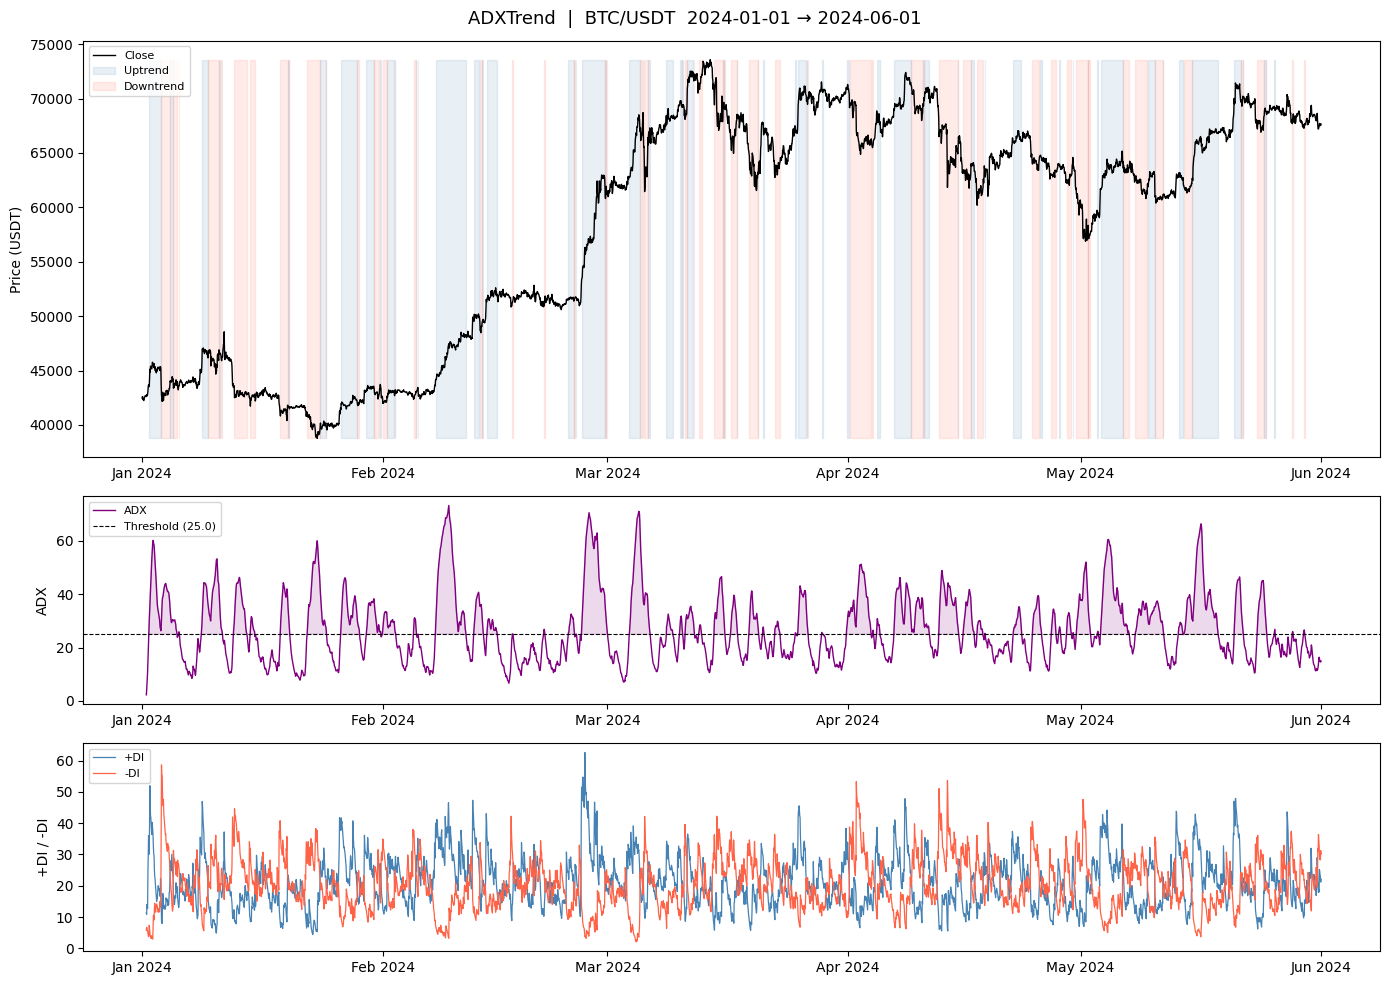

In [5]:
fig = plt.figure(figsize=(14, 10))
gs  = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
fig.suptitle(f"ADXTrend  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)

ax0 = fig.add_subplot(gs[0])
ax0.plot(adx_df.index, adx_df["close"], lw=1, color="black", label="Close")
ax0.fill_between(adx_df.index, adx_df["close"].min(), adx_df["close"].max(),
                 where=(adx_df["trend_dir"] ==  1), alpha=0.12, color="steelblue", label="Uptrend")
ax0.fill_between(adx_df.index, adx_df["close"].min(), adx_df["close"].max(),
                 where=(adx_df["trend_dir"] == -1), alpha=0.12, color="tomato",    label="Downtrend")
ax0.set_ylabel("Price (USDT)")
ax0.legend(loc="upper left", fontsize=8)

ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax1.plot(adx_df.index, adx_df["adx"], lw=1, color="purple", label="ADX")
ax1.axhline(ADX_THRESHOLD, color="black", lw=0.8, ls="--", label=f"Threshold ({ADX_THRESHOLD})")
ax1.fill_between(adx_df.index, ADX_THRESHOLD, adx_df["adx"],
                 where=(adx_df["adx"] >= ADX_THRESHOLD), alpha=0.15, color="purple")
ax1.set_ylabel("ADX")
ax1.legend(loc="upper left", fontsize=8)

ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax2.plot(adx_df.index, adx_df["plus_di"],  lw=0.9, color="steelblue", label="+DI")
ax2.plot(adx_df.index, adx_df["minus_di"], lw=0.9, color="tomato",    label="-DI")
ax2.set_ylabel("+DI / -DI")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax2.legend(loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

### A2. MASlopeTrend

In [6]:
slope_signal = MASlopeTrend(ma_period=MA_PERIOD, slope_window=SLOPE_WINDOW, flat_threshold=FLAT_THRESHOLD)
slope_df     = slope_signal.compute(df)

print(slope_signal)
print(f"\ntrend_dir counts:\n{slope_df['trend_dir'].value_counts().sort_index()}")

MASlopeTrend(ma_period=20, slope_window=5, flat_threshold=0.05)

trend_dir counts:
trend_dir
-1     890
 0    1597
 1    1162
Name: count, dtype: int64


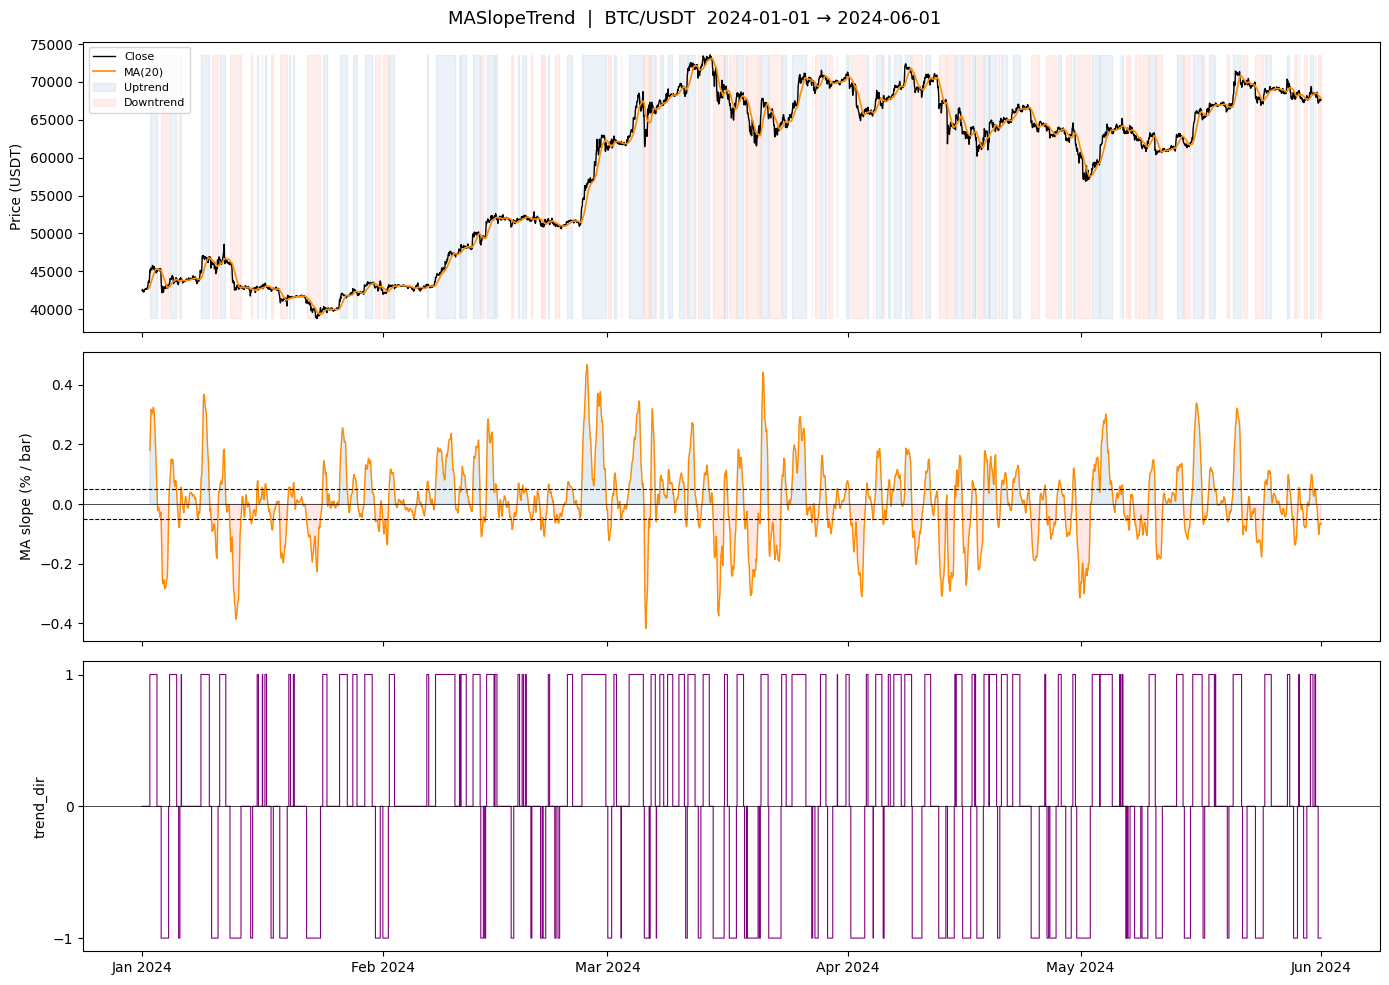

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle(f"MASlopeTrend  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)

ax = axes[0]
ax.plot(slope_df.index, slope_df["close"], lw=1,   color="black",     label="Close")
ax.plot(slope_df.index, slope_df["ma"],    lw=1.2, color="darkorange", label=f"MA({MA_PERIOD})")
ax.fill_between(slope_df.index, slope_df["close"].min(), slope_df["close"].max(),
                where=(slope_df["trend_dir"] ==  1), alpha=0.10, color="steelblue", label="Uptrend")
ax.fill_between(slope_df.index, slope_df["close"].min(), slope_df["close"].max(),
                where=(slope_df["trend_dir"] == -1), alpha=0.10, color="tomato",    label="Downtrend")
ax.set_ylabel("Price (USDT)")
ax.legend(loc="upper left", fontsize=8)

ax = axes[1]
ax.plot(slope_df.index, slope_df["ma_slope_pct"], lw=1, color="darkorange")
ax.axhline( FLAT_THRESHOLD, color="black", lw=0.8, ls="--")
ax.axhline(-FLAT_THRESHOLD, color="black", lw=0.8, ls="--")
ax.axhline(0, color="black", lw=0.5)
ax.fill_between(slope_df.index, 0, slope_df["ma_slope_pct"],
                where=(slope_df["ma_slope_pct"] > 0), alpha=0.15, color="steelblue")
ax.fill_between(slope_df.index, 0, slope_df["ma_slope_pct"],
                where=(slope_df["ma_slope_pct"] < 0), alpha=0.15, color="tomato")
ax.set_ylabel("MA slope (% / bar)")

ax = axes[2]
ax.step(slope_df.index, slope_df["trend_dir"], where="post", lw=0.8, color="purple")
ax.axhline(0, color="black", lw=0.5)
ax.set_yticks([-1, 0, 1])
ax.set_ylabel("trend_dir")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.tight_layout()
plt.show()

### A3. Signal agreement & distribution

In [8]:
combined = pd.DataFrame({
    "adx":           adx_df["adx"],
    "adx_dir":       adx_df["trend_dir"],
    "slope_pct":     slope_df["ma_slope_pct"],
    "slope_dir":     slope_df["trend_dir"],
    "market_return": df["close"].pct_change(),
}).dropna()

agree = (combined["adx_dir"] == combined["slope_dir"]).mean() * 100
print(f"Signals agree on direction: {agree:.1f}% of bars")

crosstab = pd.crosstab(
    combined["adx_dir"].map({-1: "ADX down", 0: "ADX flat", 1: "ADX up"}),
    combined["slope_dir"].map({-1: "Slope down", 0: "Slope flat", 1: "Slope up"}),
    margins=True
)
print("\nCross-tabulation of trend_dir (bar counts):")
display(crosstab)

Signals agree on direction: 70.8% of bars

Cross-tabulation of trend_dir (bar counts):


slope_dir,Slope down,Slope flat,Slope up,All
adx_dir,,,,
ADX down,639,168,60,867
ADX flat,225,1203,378,1806
ADX up,26,202,724,952
All,890,1573,1162,3625


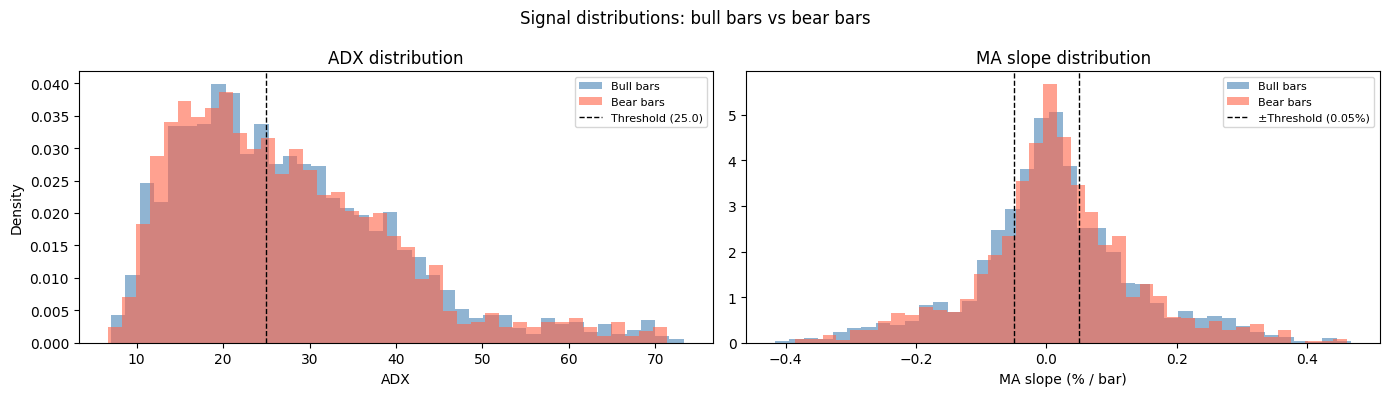

In [9]:
bull_bars = combined[combined["market_return"] > 0]
bear_bars = combined[combined["market_return"] < 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("Signal distributions: bull bars vs bear bars", fontsize=12)

ax = axes[0]
ax.hist(bull_bars["adx"], bins=40, alpha=0.6, color="steelblue", label="Bull bars", density=True)
ax.hist(bear_bars["adx"], bins=40, alpha=0.6, color="tomato",    label="Bear bars", density=True)
ax.axvline(ADX_THRESHOLD, color="black", lw=1, ls="--", label=f"Threshold ({ADX_THRESHOLD})")
ax.set_xlabel("ADX")
ax.set_ylabel("Density")
ax.set_title("ADX distribution")
ax.legend(fontsize=8)

ax = axes[1]
ax.hist(bull_bars["slope_pct"], bins=40, alpha=0.6, color="steelblue", label="Bull bars", density=True)
ax.hist(bear_bars["slope_pct"], bins=40, alpha=0.6, color="tomato",    label="Bear bars", density=True)
ax.axvline( FLAT_THRESHOLD, color="black", lw=1, ls="--")
ax.axvline(-FLAT_THRESHOLD, color="black", lw=1, ls="--", label=f"±Threshold ({FLAT_THRESHOLD}%)")
ax.set_xlabel("MA slope (% / bar)")
ax.set_title("MA slope distribution")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## Part B — Filtered Backtest

Baseline: `BollingerBreakout` with no filter.

Filtered variants — only enter a position when the trend signal agrees:
- **ADX filter**: only trade when `adx >= ADX_THRESHOLD`
- **Slope filter**: only trade in the direction the MA slope is pointing
- **Both filters**: both conditions must hold simultaneously

In [10]:
def build_equity_curve(signal: pd.Series) -> pd.Series:
    market_ret = df["close"].pct_change().fillna(0)
    position   = signal.shift(1).fillna(0)
    equity     = (1 + position * market_ret).cumprod()
    equity.name = "equity"
    return equity

bo_df          = BollingerBreakout(period=BB_PERIOD, num_std=BB_NUM_STD).generate_signals(df)
base_sig       = bo_df["signal"]
adx_trending   = adx_df["adx"] >= ADX_THRESHOLD
slope_dir      = slope_df["trend_dir"]
slope_agree    = (base_sig == slope_dir) | (slope_dir == 0)

adx_filtered   = base_sig.where(adx_trending, 0)
slope_filtered = base_sig.where((slope_dir != 0) & slope_agree, 0)
both_filtered  = base_sig.where(adx_trending & (slope_dir != 0) & slope_agree, 0)

variants = {
    "Unfiltered":   build_equity_curve(base_sig),
    "ADX filter":   build_equity_curve(adx_filtered),
    "Slope filter": build_equity_curve(slope_filtered),
    "Both filters": build_equity_curve(both_filtered),
}

print("Position counts per variant (non-zero bars):")
for name, sig in [("Unfiltered", base_sig), ("ADX filter", adx_filtered),
                  ("Slope filter", slope_filtered), ("Both filters", both_filtered)]:
    print(f"  {name:<15} {(sig != 0).sum():>5} bars active")

Position counts per variant (non-zero bars):
  Unfiltered        421 bars active
  ADX filter        202 bars active
  Slope filter      223 bars active
  Both filters      137 bars active


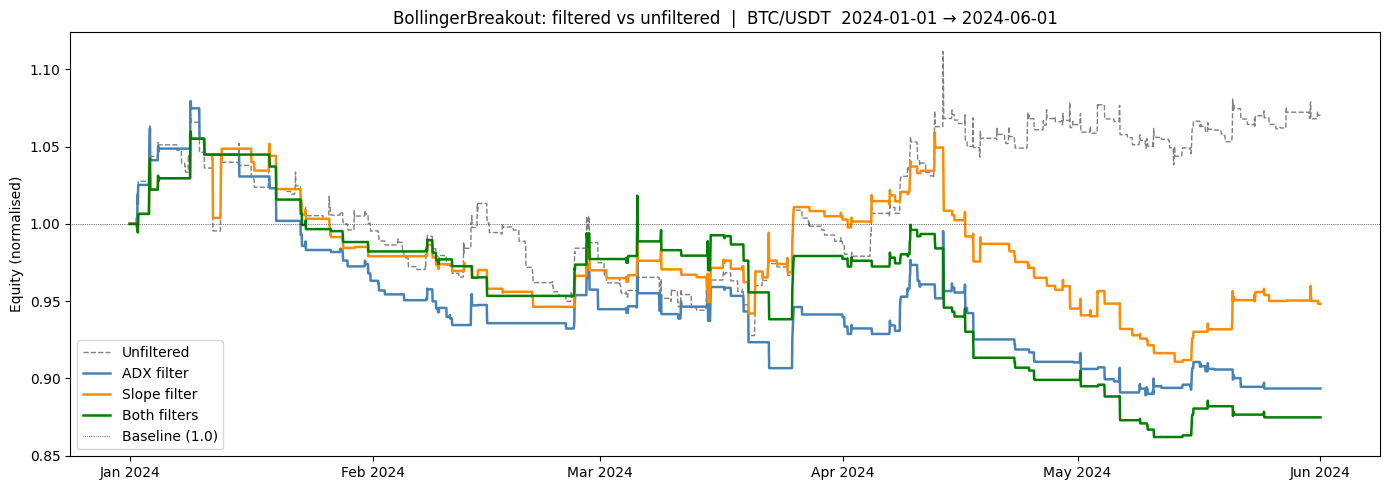

In [11]:
colors = {"Unfiltered": "grey", "ADX filter": "steelblue",
          "Slope filter": "darkorange", "Both filters": "green"}

fig, ax = plt.subplots(figsize=(14, 5))
for name, equity in variants.items():
    ax.plot(equity.index, equity, label=name, color=colors[name],
            lw=1.8 if name != "Unfiltered" else 1.0,
            ls="--" if name == "Unfiltered" else "-")
ax.axhline(1, color="black", lw=0.5, ls=":", label="Baseline (1.0)")
ax.set_title(f"BollingerBreakout: filtered vs unfiltered  |  {SYMBOL}  {SINCE} → {UNTIL}")
ax.set_ylabel("Equity (normalised)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.tight_layout()
plt.show()

### B1. Metrics comparison

In [12]:
all_metrics = {name: compute_metrics(equity) for name, equity in variants.items()}
comparison  = pd.DataFrame(all_metrics)

pct_rows = {"total_return", "mean_return", "std_return",
            "mean_neg_return", "std_neg_return",
            "return_p05", "return_p25", "return_p75", "return_p95",
            "max_drawdown", "win_rate"}

def fmt(row_name, val):
    if pd.isna(val): return "nan"
    return f"{val*100:.2f}%" if row_name in pct_rows else f"{val:.4f}"

formatted = comparison.apply(lambda col: [fmt(idx, v) for idx, v in col.items()])
formatted.index = comparison.index
formatted

,Unfiltered,ADX filter,Slope filter,Both filters
total_return,7.03%,-10.66%,-5.18%,-12.53%
mean_return,0.00%,-0.00%,-0.00%,-0.00%
std_return,0.28%,0.21%,0.22%,0.18%
sharpe_ratio,0.7582,-1.2604,-0.5103,-1.8368
sortino_ratio,0.4183,-0.4759,-0.1869,-0.5362
mean_neg_return,-0.48%,-0.60%,-0.60%,-0.69%
std_neg_return,0.50%,0.56%,0.61%,0.61%
return_p05,-0.16%,0.00%,0.00%,0.00%
return_p25,0.00%,0.00%,0.00%,0.00%
return_p75,0.00%,0.00%,0.00%,0.00%


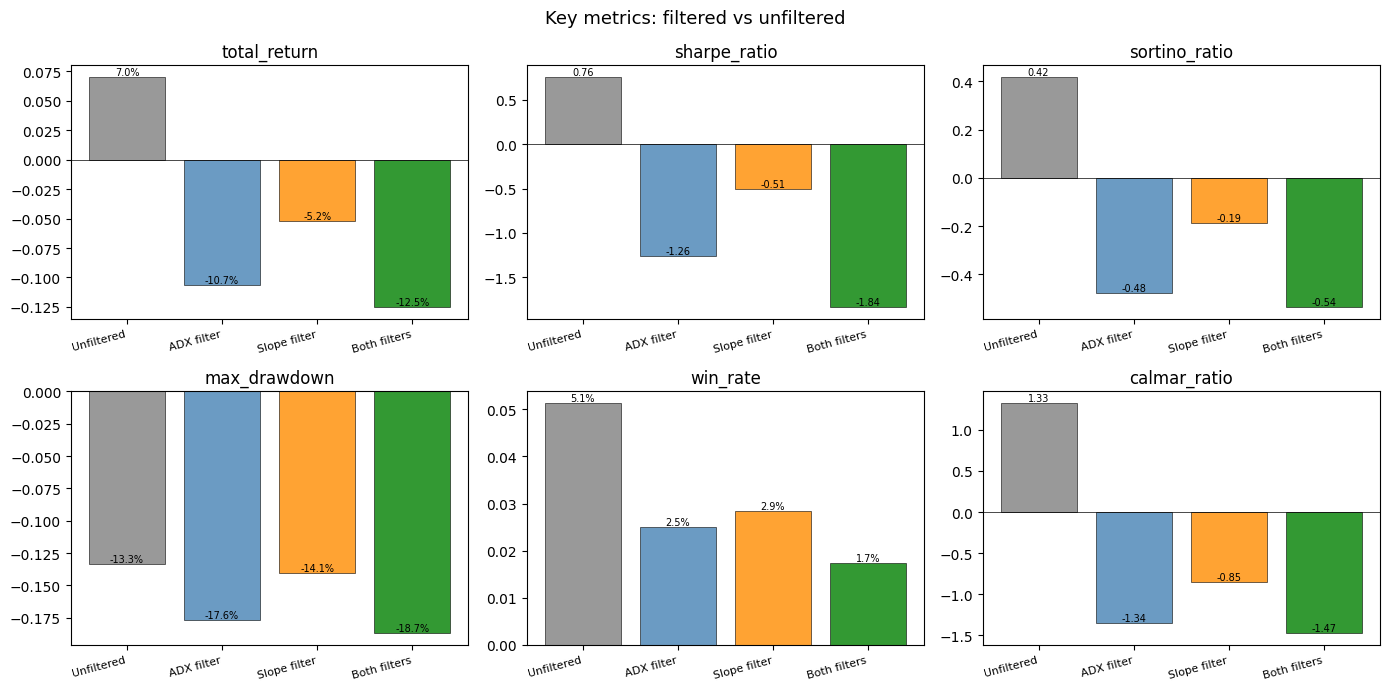

In [13]:
key_metrics = ["total_return", "sharpe_ratio", "sortino_ratio", "max_drawdown", "win_rate", "calmar_ratio"]
labels      = list(variants.keys())
bar_colors  = [colors[l] for l in labels]

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
fig.suptitle("Key metrics: filtered vs unfiltered", fontsize=13)

for ax, metric in zip(axes.flat, key_metrics):
    vals = [all_metrics[l][metric] for l in labels]
    bars = ax.bar(labels, vals, color=bar_colors, alpha=0.8, edgecolor="black", lw=0.5)
    ax.axhline(0, color="black", lw=0.5)
    ax.set_title(metric)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=15, ha="right", fontsize=8)
    for bar, val in zip(bars, vals):
        if not np.isnan(val):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f"{val*100:.1f}%" if metric in pct_rows else f"{val:.2f}",
                    ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()

### B2. Interpretation

> **Why do the trend filters hurt `BollingerBreakout` here?**
>
> `BollingerBreakout` is a **momentum strategy**: it enters the moment price
> breaks out of the bands, betting the move continues. The best risk/reward
> is right at the start of the breakout — before a trend is confirmed.
>
> Both `ADXTrend` and `MASlopeTrend` are **lagging indicators**: they
> smooth past prices, so they only confirm a trend *after* it has been
> underway for several bars. By the time ADX crosses 25 or the MA slope
> tilts clearly, much of the breakout move has already been captured —
> or worse, the move is exhausting and a reversal is near.
>
> **The filters are not "bad" signals — they are mismatched to this strategy.**
> They would be more useful for:
> - A *mean-reversion* strategy that wants to avoid trending regimes
>   (i.e., sit out when ADX > 25, trade when ADX < 20).
> - An *advanced* strategy that combines entry timing from one signal
>   with trend confirmation from another at a different time scale.
>
> See Part C below to understand how predictive these signals actually are
> about future market direction before judging their value.

### B3. Market correlation of filtered strategies

In [14]:
market_ret = df["close"].pct_change()
strat_rets = pd.concat([
    market_ret.rename("market"),
    (base_sig.shift(1).fillna(0)       * market_ret).rename("Unfiltered"),
    (adx_filtered.shift(1).fillna(0)   * market_ret).rename("ADX filter"),
    (slope_filtered.shift(1).fillna(0) * market_ret).rename("Slope filter"),
    (both_filtered.shift(1).fillna(0)  * market_ret).rename("Both filters"),
], axis=1).dropna()

cols = ["Unfiltered", "ADX filter", "Slope filter", "Both filters"]

bull = strat_rets[strat_rets["market"] > 0]
bear = strat_rets[strat_rets["market"] < 0]

cond_corr = pd.DataFrame({
    "bull_mkt (mkt>0)": bull[cols].corrwith(bull["market"]),
    "bear_mkt (mkt<0)": bear[cols].corrwith(bear["market"]),
    "all_bars":         strat_rets[cols].corrwith(strat_rets["market"]),
})
print(f"Conditional correlation  ({len(bull):,} bull / {len(bear):,} bear bars):")
display(cond_corr.style.format("{:.3f}").background_gradient(cmap="RdYlGn", vmin=-1, vmax=1))

Conditional correlation  (1,879 bull / 1,768 bear bars):


,bull_mkt (mkt>0),bear_mkt (mkt<0),all_bars
Unfiltered,0.048,-0.189,-0.056
ADX filter,-0.081,-0.220,-0.122
Slope filter,-0.017,-0.082,-0.037
Both filters,-0.099,-0.113,-0.085


---
## Part C — Prediction Precision Evaluation

Treat each signal's `trend_dir` as a **directional forecast** and ask:
when the signal says "up" (+1), how often is the market actually up over
the next N bars?

- **Directional accuracy**: fraction of non-flat predictions that were correct
- **Precision by class**: of all "up" predictions, how many were correct? Same for "down"
- **Multi-horizon accuracy**: does accuracy persist beyond 1 bar?
- **Precision vs threshold**: does tightening the threshold (higher ADX, steeper slope) improve precision?

In [15]:
def future_direction(close: pd.Series, horizon: int) -> pd.Series:
    """Actual market direction over the next `horizon` bars.
    +1 if close[t+horizon] > close[t], -1 otherwise.
    """
    fwd_return = close.shift(-horizon) / close - 1
    return fwd_return.apply(lambda x: 1 if x > 0 else -1)


def precision_recall(pred: pd.Series, actual: pd.Series):
    """Compute per-class precision, recall, and overall directional accuracy.
    Only evaluates on bars where pred != 0.
    """
    mask   = pred != 0
    p      = pred[mask]
    a      = actual[mask]
    correct = (p == a).sum()
    total   = len(p)
    rows = []
    for cls, label in [(1, "up (+1)"), (-1, "down (-1)")]:
        tp = ((p == cls) & (a == cls)).sum()
        fp = ((p == cls) & (a != cls)).sum()
        fn = ((p != cls) & (a == cls)).sum()
        prec = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
        rec  = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else float("nan")
        rows.append({"class": label, "precision": prec, "recall": rec,
                     "f1": f1, "support": int(tp + fn)})
    acc = correct / total if total > 0 else float("nan")
    return pd.DataFrame(rows).set_index("class"), acc, total


print("Helper functions defined.")

Helper functions defined.


### C1. Accuracy at multiple horizons

In [16]:
horizon_rows = []
for h in HORIZONS:
    actual = future_direction(df["close"], h)
    for sig_name, trend_dir in [("ADXTrend", adx_df["trend_dir"]),
                                 ("MASlopeTrend", slope_df["trend_dir"])]:
        _, acc, n_pred = precision_recall(trend_dir, actual)
        # naive baseline: always predict +1
        baseline_acc = (actual[trend_dir != 0] == 1).mean()
        horizon_rows.append({"signal": sig_name, "horizon (bars)": h,
                              "accuracy": acc, "n_predictions": n_pred,
                              "naive_baseline": baseline_acc})

horizon_df = pd.DataFrame(horizon_rows)
display(horizon_df.style.format({
    "accuracy":       "{:.3f}",
    "naive_baseline": "{:.3f}",
}).background_gradient(subset=["accuracy"], cmap="RdYlGn", vmin=0.4, vmax=0.7))

,signal,horizon (bars),accuracy,n_predictions,naive_baseline
0,ADXTrend,1,0.474,1822,0.526
1,MASlopeTrend,1,0.471,2052,0.517
2,ADXTrend,4,0.477,1822,0.544
3,MASlopeTrend,4,0.468,2052,0.510
4,ADXTrend,12,0.450,1822,0.554
5,MASlopeTrend,12,0.430,2052,0.514
6,ADXTrend,24,0.431,1822,0.567
7,MASlopeTrend,24,0.435,2052,0.546


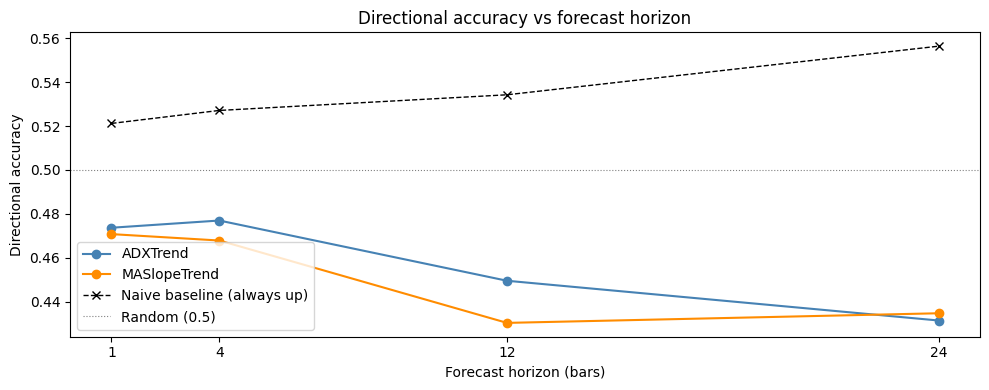

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
for sig_name, color in [("ADXTrend", "steelblue"), ("MASlopeTrend", "darkorange")]:
    sub = horizon_df[horizon_df["signal"] == sig_name]
    ax.plot(sub["horizon (bars)"], sub["accuracy"], marker="o", lw=1.5,
            color=color, label=sig_name)
baseline = horizon_df.groupby("horizon (bars)")["naive_baseline"].mean()
ax.plot(baseline.index, baseline.values, lw=1, ls="--", color="black",
        marker="x", label="Naive baseline (always up)")
ax.axhline(0.5, color="grey", lw=0.8, ls=":", label="Random (0.5)")
ax.set_xlabel("Forecast horizon (bars)")
ax.set_ylabel("Directional accuracy")
ax.set_title("Directional accuracy vs forecast horizon")
ax.set_xticks(HORIZONS)
ax.legend()
plt.tight_layout()
plt.show()

### C2. Precision & recall by class (1-bar horizon)

In [18]:
actual_1bar = future_direction(df["close"], 1)

for sig_name, trend_dir in [("ADXTrend", adx_df["trend_dir"]),
                             ("MASlopeTrend", slope_df["trend_dir"])]:
    pr_df, acc, n = precision_recall(trend_dir, actual_1bar)
    coverage = n / len(df) * 100
    print(f"\n── {sig_name}  (accuracy={acc:.3f}, {n} predictions, {coverage:.1f}% coverage) ──")
    display(pr_df.style.format("{:.3f}").background_gradient(cmap="RdYlGn", vmin=0.3, vmax=0.7))


── ADXTrend  (accuracy=0.474, 1822 predictions, 49.9% coverage) ──


,precision,recall,f1,support
class,,,,
up (+1),0.499,0.498,0.499,958.000
down (-1),0.445,0.447,0.446,864.000



── MASlopeTrend  (accuracy=0.471, 2052 predictions, 56.2% coverage) ──


,precision,recall,f1,support
class,,,,
up (+1),0.489,0.536,0.511,1060.000
down (-1),0.447,0.401,0.423,992.000


### C3. Confusion matrix (1-bar horizon)

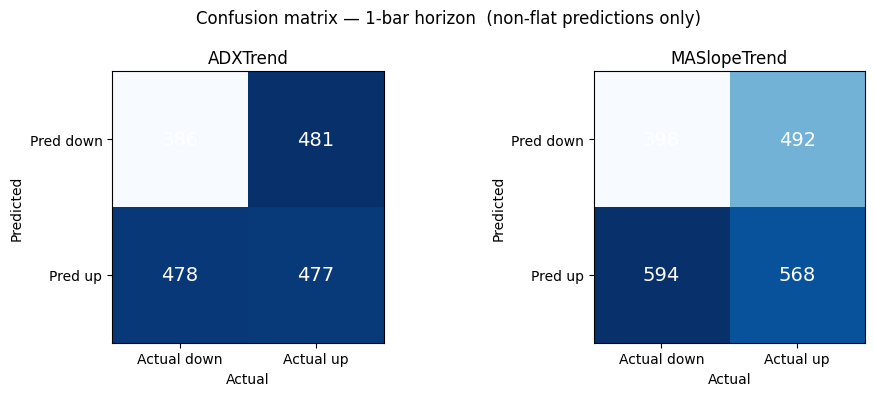

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Confusion matrix — 1-bar horizon  (non-flat predictions only)", fontsize=12)

for ax, (sig_name, trend_dir) in zip(axes, [("ADXTrend", adx_df["trend_dir"]),
                                             ("MASlopeTrend", slope_df["trend_dir"])]):
    mask  = trend_dir != 0
    pred  = trend_dir[mask]
    truth = actual_1bar[mask]
    matrix = pd.crosstab(
        pred.map({1: "Pred up", -1: "Pred down"}),
        truth.map({1: "Actual up", -1: "Actual down"}),
    )
    im = ax.imshow(matrix.values, cmap="Blues")
    ax.set_xticks([0, 1]); ax.set_xticklabels(matrix.columns)
    ax.set_yticks([0, 1]); ax.set_yticklabels(matrix.index)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(sig_name)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(matrix.values[i, j]), ha="center", va="center",
                    fontsize=14, color="white" if matrix.values[i, j] > matrix.values.max() / 2 else "black")

plt.tight_layout()
plt.show()

### C4. Precision vs threshold

Does requiring a stronger signal (higher ADX, steeper slope) yield better
directional precision — at the cost of fewer predictions (lower coverage)?

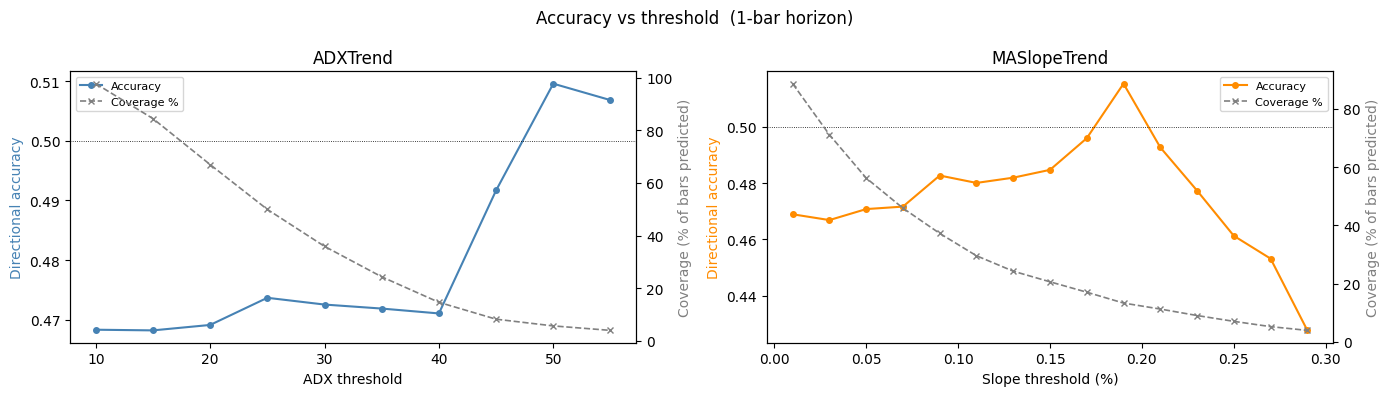

In [20]:
adx_thresholds   = np.arange(10, 60, 5)
slope_thresholds = np.arange(0.01, 0.30, 0.02)

adx_results, slope_results = [], []

for thresh in adx_thresholds:
    sig    = ADXTrend(period=ADX_PERIOD, trend_threshold=thresh).compute(df)["trend_dir"]
    _, acc, n = precision_recall(sig, actual_1bar)
    adx_results.append({"threshold": thresh, "accuracy": acc,
                         "coverage_pct": n / len(df) * 100})

for thresh in slope_thresholds:
    sig    = MASlopeTrend(ma_period=MA_PERIOD, slope_window=SLOPE_WINDOW,
                          flat_threshold=thresh).compute(df)["trend_dir"]
    _, acc, n = precision_recall(sig, actual_1bar)
    slope_results.append({"threshold": thresh, "accuracy": acc,
                           "coverage_pct": n / len(df) * 100})

adx_res_df   = pd.DataFrame(adx_results)
slope_res_df = pd.DataFrame(slope_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("Accuracy vs threshold  (1-bar horizon)", fontsize=12)

for ax, res_df, label, color, xlabel in [
    (axes[0], adx_res_df,   "ADXTrend",    "steelblue",  "ADX threshold"),
    (axes[1], slope_res_df, "MASlopeTrend", "darkorange", "Slope threshold (%)"),
]:
    ax2 = ax.twinx()
    ax.plot(res_df["threshold"], res_df["accuracy"],    color=color, lw=1.5, marker="o", ms=4, label="Accuracy")
    ax2.plot(res_df["threshold"], res_df["coverage_pct"], color="grey", lw=1.2, ls="--", marker="x", ms=4, label="Coverage %")
    ax.axhline(0.5, color="black", lw=0.6, ls=":")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Directional accuracy", color=color)
    ax2.set_ylabel("Coverage (% of bars predicted)", color="grey")
    ax.set_title(label)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.tight_layout()
plt.show()